In [590]:
# Variables for configuration
generate_pandas_profiling_reports = False 
process_preprocessed_data_of_uci = False
print_pair_plots = False

In [591]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [592]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [593]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys 
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = dataString.replace("name ","name\n")
        dataString = dataString.replace(" ",",")
        return dataString

In [594]:
# read the data from the specified datasets into the df 
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [595]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

# Data cleanup

In [596]:
# the dataset encodes unfilled cells with -9 they are replaced with NaN for better compatibility with pd
df = df.replace(-9, float('nan'))

In [597]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df, title='Pandas Profiling Report for all features')
    profile.to_file("Pandas Profiling Report for all features.html")

The columns smoke and years both describe whether a respondent smokes or not. Smoke does this by being binary coded, while years describes the number of years a person has smoked. Due to the high number of missing values, the columns are useless on their own. However, it is possible to enrich the smoke column with the years column. 

In [598]:
print(f"Number of NaNs in smoke: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['years'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['years'] > 0),'smoke'] = 1
df.drop(columns=['smoke'])
print(f"Number of NaNs in smoke after combination with years: {df['smoke'].isna().sum()}")
df.loc[(df['smoke'].isna()) & (df['cigs'] == 0),'smoke'] = 0
df.loc[(df['smoke'].isna()) & (df['cigs'] > 0),'smoke'] = 1
print(f"Number of NaNs in smoke after combination with years and cigs: {df['smoke'].isna().sum()}")

Number of NaNs in smoke: 671
Number of NaNs in smoke after combination with years: 391
Number of NaNs in smoke after combination with years and cigs: 389


Finding: reduces the number of missing values in smoke by 280 entries. 

## Explore how many NaNs and zeros are within one column for each attribute.

In [599]:
(df.loc[ : , df.columns != 'dataset'].isna()).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,282,282,282,282,0,0,0,0,4,5,5,0,259,0,0,0,0,0,2,2,2,2,2,0,0,69,0,0,0,0,0,0,0,0,0,0,0,282,0,2,282,282,282,282,282,282,2,282,282,282,0,0,0,0,0,0,0,282,0,282,0,282,0,0,0,0,0,0,0,282,282,0
hungarian,1,1,1,1,1,1,1,295,1,2,2,24,283,294,295,9,274,294,2,1,1,1,2,3,2,2,2,10,3,191,3,2,2,2,2,2,2,2,3,1,191,2,1,291,295,295,295,292,295,293,267,268,278,295,1,1,1,1,276,237,247,277,236,286,272,290,245,270,1,1,1,1,1,267,295,1
long-beach-va,1,1,1,1,1,1,5,201,1,57,4,8,2,11,13,8,158,9,1,53,54,53,61,61,60,60,74,54,54,161,54,54,55,60,60,57,57,54,54,57,102,66,66,199,201,200,173,174,199,198,160,170,200,200,3,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,4,24,82,1
switzerland,0,0,0,0,0,0,0,123,0,2,30,0,100,112,121,75,115,121,1,1,1,1,5,2,3,1,6,50,1,34,50,1,1,3,3,2,2,1,3,6,17,77,77,118,123,123,123,123,123,123,50,51,97,123,9,9,9,0,0,0,0,0,0,0,0,0,0,0,17,17,17,17,13,17,123,0


In [600]:
(df.loc[ : , df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,id,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num,lmt,ladprox,laddist,diag,cxmain,ramus,om1,om2,rcaprox,rcadist,lvx1,lvx2,lvx3,lvx4,lvf,cathef,junk,name
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,282,0,91,0,0,0,0,0,0,108,0,115,115,115,240,0,107,138,0,0,0,271,186,211,252,248,0,0,43,0,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,294,0,81,23,164,141,0,0,0,195,0,10,0,0,266,0,1,235,0,0,0,293,274,265,269,290,0,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,0,0,3,0,2,0,6,7,0,0,0,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,200,0,6,15,65,33,0,0,1,90,49,96,38,38,125,4,100,80,0,0,0,122,88,61,105,94,0,0,2,0,0,0,0,0,1,1,52,139,40,1,0,0,2,0,1,0,10,0,2,0,9,1,1,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
switzerland,0,123,0,10,11,22,27,0,0,0,60,123,5,0,0,43,0,0,85,0,0,0,116,70,75,66,93,0,0,25,0,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,0,0,21,23,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Treatment of different scales in the datasets
### met

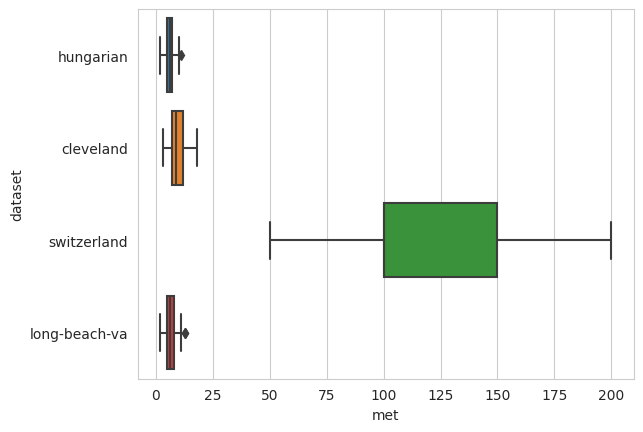

In [601]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

In [602]:
df.loc[df["dataset"] == "switzerland", "met"] = df.loc[df["dataset"] == "switzerland", "met"]/10

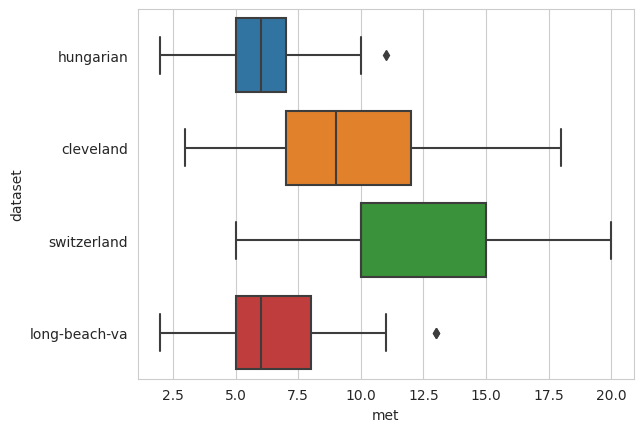

In [603]:
# plot to show the reason why we need to process this data:
sns.boxplot(x="met",y="dataset",data= df)
plt.show()

### rldv5e

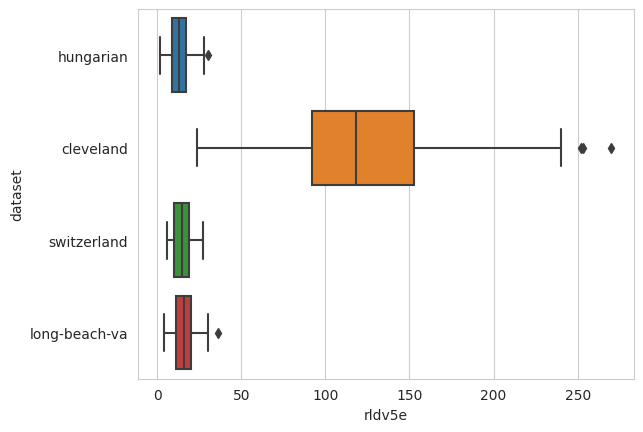

In [604]:
# plot to show the reason why we need to process this data: 
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

In [605]:
df.loc[df["dataset"] == "cleveland", "rldv5e"] = df.loc[df["dataset"] == "cleveland", "rldv5e"]/10

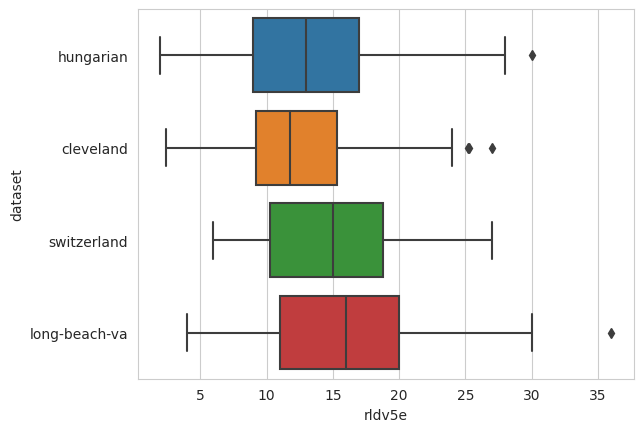

In [606]:
# plot to show the reason why we drop:
sns.boxplot(x="rldv5e",y="dataset",data= df)
plt.show()

### drop columns that are not used for prediction

In [607]:
columns_to_drop = [
    "id",
    "painloc",
    "painexer",
    "relrest",
    "ccf",
    "pncaden",
    "chol",
    "smoke",
    "years",
    "cigs",
    "dm",
    "famhist",
    "ekgmo",
    "ekgday",
    "ekgyr",
    "dig",
    "prop",
    "nitr",
    "diuretic",
    "proto",
    "thaldur",
    "thaltime",
    "dummy",
    "xhypo",
    "slope",
    "rldv5",
    "ca",
    "restckm",
    "exerckm",
    "restef",
    "restwm",
    "exeref",
    "exerwm",
    "thal",
    "thalsev",
    "thalpul",
    "earlobe",
    "cmo",
    "cday",
    "cyr",
    "lmt",
    "ladprox",
    "laddist",
    "diag",
    "cxmain",
    "ramus",
    "om1",
    "om2",
    "rcaprox",
    "rcadist",
    "lvx1",
    "lvx2",
    "lvx3",
    "lvx4",
    "lvf",
    "cathef",
    "junk",
    "name"
]
df.drop(columns_to_drop, inplace=True, axis=1)

In [608]:
# All values beyond 18 are not realistic -> also 18 is a value that is only archived by very sporty people
# https://blog.nasm.org/metabolic-equivalents-for-weight-loss
print(f"Shape before drop of met vlaues that are unrealistic: {df.shape}")
df.drop(df[df['met']> 18].index, inplace=True, axis=0)
print(f"Shape after drop of met vlaues that are unrealistic: {df.shape}")

Shape before drop of met vlaues that are unrealistic: (901, 19)
Shape after drop of met vlaues that are unrealistic: (900, 19)


In [609]:
# leave the dead ones behind
# drop entries with a blood pressure of 0
print(f"Shape before drop of entrys with a blood preasure of 0: {df.shape}")
df.drop(df[df['trestbps'] == 0].index, inplace=True, axis=0)
print(f"Shape after drop of entrys with a blood preasure of 0: {df.shape}")

Shape before drop of entrys with a blood preasure of 0: (900, 19)
Shape after drop of entrys with a blood preasure of 0: (899, 19)


In [610]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df, title='Pandas Profiling Report for selected features')
    profile.to_file("Pandas Profiling Report for selected features.html")

In [611]:
# drop all entries which contain one or more NanN vlaues
print(f"Shape before drop of NaN containing rows: {df.shape}")
df.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df.shape}")

Shape before drop of NaN containing rows: (899, 19)
Shape after drop of NaN containing rows: (679, 19)


# Visualize Data

In [612]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

In [613]:
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

In [614]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df.loc[df['num'] >= 1,"num"] = 1
df['num'] = labelEncoder.fit_transform(df['num'])

In [615]:
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")

<AxesSubplot:>

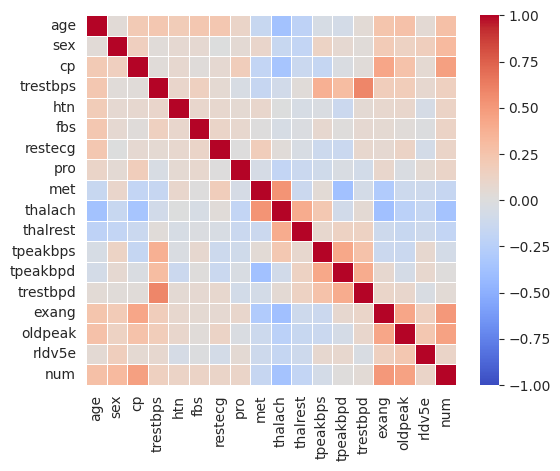

In [616]:
# Compute the correlation matrix
corr = df.corr()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)

# Train the different models

In [617]:
X = df.loc[:,(df.columns!= 'num') & (df.columns != 'dataset')]
y = df['num']

In [618]:
from sklearn.exceptions import FitFailedWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from  sklearn.naive_bayes import *

estimators_and_hyperparameters=[
    {"estimator": CatBoostClassifier(random_state=42, thread_count=-1, silent= True), "parameters": {}},
    {"estimator": XGBClassifier(random_state=42, n_jobs=-1), "parameters": {'classification__n_estimators': [100,125,150,175,200,225,250],
                                                                            'classification__max_depth': [2,4,6,8,10]}},
    {"estimator": SVC(kernel='linear',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='poly',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='rbf',random_state=42), "parameters": {}},
    {"estimator": SVC(kernel='sigmoid',random_state=42), "parameters": {}},
    # only for square matrix -> not used {"estimator": SVC(kernel='precomputed',random_state=42), "parameters": {}},
    {"estimator": BernoulliNB(), "parameters": {}},
    {"estimator": CategoricalNB(), "parameters": {}},
    {"estimator": ComplementNB(), "parameters": {}},
    {"estimator": GaussianNB(), "parameters": {}},
    {"estimator": MultinomialNB(), "parameters": {}},
    {"estimator": DecisionTreeClassifier(random_state=42), "parameters": {}},
    {"estimator": KNeighborsClassifier(n_jobs=-1), "parameters": {'classification__n_neighbors': range(2, 9)}},
    {"estimator": RandomForestClassifier(random_state=42, n_jobs=-1), "parameters": {}},
    {"estimator": SGDClassifier(), "parameters": {}}
]

In [619]:
from sklearn.preprocessing import *
scalers = [
    {"scaler": MaxAbsScaler(), "parameters": {}},
    {"scaler": MinMaxScaler(), "parameters": {}},
    {"scaler": Normalizer(), "parameters": {}},
    {"scaler": PowerTransformer(), "parameters": {}},
    {"scaler": RobustScaler(), "parameters": {}},
    {"scaler": StandardScaler(), "parameters": {'normalisation__with_mean': [ True, False],'normalisation__with_std': [ True, False]}}
]

In [620]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# build pipelines
# create the pipeline
pipelines = []
for scaler in scalers:
    print(f"Scaler: {scaler.get('scaler').__class__.__name__}")
    for estimator in estimators_and_hyperparameters:
        parameters = scaler.get("parameters") | estimator.get("parameters")
        pipeline = Pipeline(steps=[ ('normalisation', scaler.get("scaler")), ('classification', estimator.get("estimator")) ])
        # create the grid search instance
        grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=10, error_score='raise')
        try:
            accuracy_best = cross_val_score(grid_search_estimator, X, y, cv=10, scoring='accuracy', n_jobs=-1, error_score='raise')
            grid_search_estimator.fit(X, y)
            print(f"Accuracy for {estimator.get('estimator').__class__.__name__} = {accuracy_best.mean() * 100.0}")
            display(grid_search_estimator.best_params_)
        except Exception as e:
            print(f'Skipping the combination of {scaler.get("scaler").__class__.__name__} and {estimator.get("estimator").__class__.__name__} because:')
            print(str(e))
            print()



    print("-----------------------------------------------------------------")


Scaler: MaxAbsScaler
Accuracy for CatBoostClassifier = 78.32748024582968


{}

Accuracy for XGBClassifier = 77.30026338893767


{'classification__max_depth': 2, 'classification__n_estimators': 150}

Accuracy for SVC = 78.92010535557506


{}

Accuracy for SVC = 76.56935908691835


{}

Accuracy for SVC = 77.89508340649692


{}

Accuracy for SVC = 51.97980684811239


{}

Accuracy for BernoulliNB = 75.68261633011414


{}

Accuracy for CategoricalNB = 77.60096575943811


{}

Skipping the combination of MaxAbsScaler and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 78.76646180860403


{}

Skipping the combination of MaxAbsScaler and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 72.14881474978051


{}

Accuracy for KNeighborsClassifier = 75.69798068481124


{'classification__n_neighbors': 7}

Accuracy for RandomForestClassifier = 78.47234416154521


{}

Accuracy for SGDClassifier = 74.95390693590869


{}

-----------------------------------------------------------------
Scaler: MinMaxScaler
Accuracy for CatBoostClassifier = 78.4745390693591


{}

Accuracy for XGBClassifier = 77.30026338893767


{'classification__max_depth': 2, 'classification__n_estimators': 150}

Accuracy for SVC = 78.03555750658472


{}

Accuracy for SVC = 75.09657594381036


{}

Accuracy for SVC = 77.00834064969271


{}

Accuracy for SVC = 44.920983318700614


{}

Accuracy for BernoulliNB = 74.06716417910448


{}

Skipping the combination of MinMaxScaler and CategoricalNB because:
index 1 is out of bounds for axis 1 with size 1

Accuracy for ComplementNB = 76.7208077260755


{}

Accuracy for GaussianNB = 78.76646180860403


{}

Accuracy for MultinomialNB = 76.27743634767339


{}

Accuracy for DecisionTreeClassifier = 71.85469710272169


{}

Accuracy for KNeighborsClassifier = 75.98770851624232


{'classification__n_neighbors': 7}

Accuracy for RandomForestClassifier = 78.4745390693591


{}

Accuracy for SGDClassifier = 76.12379280070236


{}

-----------------------------------------------------------------
Scaler: Normalizer
Accuracy for CatBoostClassifier = 78.4811237928007


{}

Accuracy for XGBClassifier = 79.51492537313433


{'classification__max_depth': 6, 'classification__n_estimators': 125}

Accuracy for SVC = 65.53116769095698


{}

Accuracy for SVC = 66.55179982440738


{}

Accuracy for SVC = 65.81650570676032


{}

Accuracy for SVC = 54.047410008779615


{}

Accuracy for BernoulliNB = 75.68261633011414


{}

Accuracy for CategoricalNB = 52.870939420544325


{}

Skipping the combination of Normalizer and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 77.58999122036873


{}

Skipping the combination of Normalizer and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 71.56716417910448


{}

Accuracy for KNeighborsClassifier = 58.76646180860404


{'classification__n_neighbors': 7}

Accuracy for RandomForestClassifier = 79.51273046532046


{}

Accuracy for SGDClassifier = 62.13784021071114


{}

-----------------------------------------------------------------
Scaler: PowerTransformer
Accuracy for CatBoostClassifier = 78.4745390693591


{}

Accuracy for XGBClassifier = 77.30026338893767


{'classification__max_depth': 2, 'classification__n_estimators': 150}

Accuracy for SVC = 77.59657594381035


{}

Accuracy for SVC = 75.67383669885864


{}

Accuracy for SVC = 77.00395083406497


{}

Accuracy for SVC = 76.71422300263389


{}

Accuracy for BernoulliNB = 78.18261633011413


{}

Skipping the combination of PowerTransformer and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)

Skipping the combination of PowerTransformer and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 78.18042142230027


{}

Skipping the combination of PowerTransformer and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 72.00175592625109


{}

Accuracy for KNeighborsClassifier = 78.03775241439858


{'classification__n_neighbors': 8}

Accuracy for RandomForestClassifier = 78.91571553994731


{}

Accuracy for SGDClassifier = 73.32089552238806


{}

-----------------------------------------------------------------
Scaler: RobustScaler
Accuracy for CatBoostClassifier = 78.32748024582968


{}

Accuracy for XGBClassifier = 77.30026338893767


{'classification__max_depth': 2, 'classification__n_estimators': 150}

Accuracy for SVC = 78.62598770851623


{}

Accuracy for SVC = 75.684811237928


{}

Accuracy for SVC = 78.03116769095698


{}

Accuracy for SVC = 73.77524143985953


{}

Accuracy for BernoulliNB = 75.38630377524144


{}

Skipping the combination of RobustScaler and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)

Skipping the combination of RobustScaler and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 78.76646180860403


{}

Skipping the combination of RobustScaler and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 72.00175592625109


{}

Accuracy for KNeighborsClassifier = 76.41352063213344


{'classification__n_neighbors': 7}

Accuracy for RandomForestClassifier = 78.47234416154521


{}

Accuracy for SGDClassifier = 70.39288849868306


{}

-----------------------------------------------------------------
Scaler: StandardScaler
Accuracy for CatBoostClassifier = 78.32748024582968


{'normalisation__with_mean': True, 'normalisation__with_std': False}

Accuracy for XGBClassifier = 77.15100965759439


{'classification__max_depth': 2,
 'classification__n_estimators': 150,
 'normalisation__with_mean': True,
 'normalisation__with_std': False}

Accuracy for SVC = 78.47892888498681


{'normalisation__with_mean': True, 'normalisation__with_std': True}

Accuracy for SVC = 77.89288849868305


{'normalisation__with_mean': False, 'normalisation__with_std': True}

Accuracy for SVC = 77.8884986830553


{'normalisation__with_mean': False, 'normalisation__with_std': True}

Accuracy for SVC = 77.15539947322212


{'normalisation__with_mean': True, 'normalisation__with_std': True}

Accuracy for BernoulliNB = 78.32967515364355


{'normalisation__with_mean': True, 'normalisation__with_std': True}

Skipping the combination of StandardScaler and CategoricalNB because:
Negative values in data passed to CategoricalNB (input X)

Skipping the combination of StandardScaler and ComplementNB because:
Negative values in data passed to ComplementNB (input X)

Accuracy for GaussianNB = 78.76646180860403


{'normalisation__with_mean': True, 'normalisation__with_std': True}

Skipping the combination of StandardScaler and MultinomialNB because:
Negative values in data passed to MultinomialNB (input X)

Accuracy for DecisionTreeClassifier = 71.85469710272169


{'normalisation__with_mean': True, 'normalisation__with_std': False}

Accuracy for KNeighborsClassifier = 79.36567164179104


{'classification__n_neighbors': 8,
 'normalisation__with_mean': True,
 'normalisation__with_std': True}

Accuracy for RandomForestClassifier = 78.47234416154521


{'normalisation__with_mean': False, 'normalisation__with_std': True}

Accuracy for SGDClassifier = 73.76646180860403


{'normalisation__with_mean': False, 'normalisation__with_std': True}

-----------------------------------------------------------------


In [ ]:
if not process_preprocessed_data_of_uci:
    raise SystemExit("So Feierabend Emma")

# Tests with the preprocessed data by the UCI

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
    dataset_df['dataset'] = dataset
    df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))


In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
(df_processed.loc[ : , df_processed.columns != 'dataset'].isna()).join(df_processed['dataset']).groupby("dataset").sum()

In [ ]:
df_processed.drop(["slope", "ca","thal"], inplace=True, axis=1)

In [ ]:
print(f"Shape before drop of NaN containing rows: {df_processed.shape}")
df_processed.dropna(inplace=True, axis=0, how='any')
print(f"Shape after drop of NaN containing rows: {df_processed.shape}")

In [ ]:
df_processed.shape

In [ ]:
df_processed.head()

In [ ]:
df_processed.describe()

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI.html")

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_processed.loc[df_processed['num'] >= 1,"num"] = 1
df_processed['num'] = labelEncoder.fit_transform(df_processed['num'])

In [ ]:
X = df_processed.loc[:,(df_processed.columns!= 'num') & (df_processed.columns != 'dataset')]
y = df_processed['num']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean
for scaler in scalers:
    print(f'Current Sclaer: {scaler.__class__.__name__}')
    for estimator in estimators_and_hyperparameters:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        try:
            X_trans = scaler.fit_transform(X)
            scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
            print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
        except Exception as e:
            print(e)
            print(f'Skipping the combination of {scaler.__class__.__name__} and {estimator[0].__class__.__name__}')
    print('-----------------------------------------------------------------')
print(f'Current Sclaer: NoScaler')
for estimator in estimators_and_hyperparameters:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    try:
        X_trans = X
        scores = cross_val_score(estimator[0], X_trans, y, scoring='f1',cv=skf, n_jobs=-1)
        print(f'F1 score for {estimator[0].__class__.__name__}: {mean(scores)}')
    except Exception as e:
        print(e)
        print(f'Skipping the combination of NoScaler and {estimator[0].__class__.__name__}')
print('-----------------------------------------------------------------')

In [ ]:
# Tests with the preprocessed data by the UCI includeing the reprocessed data

In [ ]:
import pandas as pd 
datasets = ["hungarian", "cleveland", "switzerland", "va"]
df_processed = pd.DataFrame()
for dataset in datasets:
    if dataset != "hungarian":
        dataset_df = pd.read_csv("./Data/processed."+ dataset +".data", header=None, sep=",")
        dataset_df['dataset'] = dataset
        df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
with open("Data/reprocessed.hungarian.data") as file:
    dataString = file.read()
    dataString = dataString.replace(" ",",")
    dataset_df = pd.read_csv(StringIO(dataString), header=None, sep=",")
    dataset_df['dataset'] = dataset
df_processed = pd.concat([df_processed,dataset_df ], ignore_index=True)
df_processed.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num', 'dataset']
df_processed = df_processed.replace('?', float('nan'))

In [ ]:
df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']] = df_processed[['trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']].apply(pd.to_numeric)

In [ ]:
df_processed

In [ ]:
if generate_pandas_profiling_reports:
    profile = ProfileReport(df_processed, title='Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian')
    profile.to_file("Pandas Profiling Report for the features processed by the UCI + reprocessed hungarian.html")